<a href="https://colab.research.google.com/github/Carlosmario90/ISYS5002_Assesments/blob/main/Assessment_Weather_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 Setup and Configuration

Import required packages and setup environment.

In [1]:

!pip install pyinputplus
import matplotlib.pyplot as plt
import pyinputplus as pyip
import pytz
!pip install ipywidgets pandas matplotlib

!pip install fetch-my-weather
import fetch_my_weather
from fetch_my_weather import get_weather

!pip install hands-on-ai
from hands_on_ai.chat import get_response
import requests

!pip install dateparser
import dateparser
import re
from datetime import datetime, timedelta

# Set your timezone — change 'Australia/Perth' or 'Australia/Sydney' as needed
local_tz = pytz.timezone('Australia/Perth')
today = datetime.now(local_tz).date()

!pip install ipywidgets
from ipywidgets import widgets, VBox, HBox, Output, Button, ToggleButtons, Layout, Label, HTML
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt




  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11349 sha256=ec698211a18413f51c7691d5fa0946da2fd9f3c25d13b19dfd552d0a1724f672
  Stored in directory: /root/.cache/pip/wheels/a3/6b/89/3bec14288af8e0729d088fb41a785e583d49e772f2529c7676
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16224 sha256=5c7586baf0f819b714abbe859f832429e961401625dfa1b9988a94894d1cad58
  Stored in directory: /root/.cache/pip/wheels/fc/40/7a/4d3b2dc2e80b4b3bbda89eec94fcefd6c8bd1101cc7bb89554
  Created wheel for stdiomask: filename=stdiomask

# Section 1 - 🌤️ Weather Data Functions

This section handles the retrieval and processing of weather data for a given location.

The function extracts:

📍 Current weather conditions (temperature, humidity, windspeed)

📆 Multi-day forecast including temperature ranges, precipitation, sunrise/sunset, and others

In [3]:
def get_weather_data(location, forecast_days):
    data = fetch_my_weather.get_weather(location=location, format="raw_json")

    current = data.get("current_condition", [{}])[0]
    raw_forecast = data.get("weather", [])

    if len(raw_forecast) < forecast_days:
        print(f"⚠️ Only {len(raw_forecast)} days of forecast data are available (not {forecast_days}).")

    forecast = raw_forecast[:forecast_days]

    return {
        "location": location,
        "current_conditions": {
            "temperature_C": current.get("temp_C"),
            "humidity": current.get("humidity"),
            "windspeed_kmph": current.get("windspeedKmph"),
            "weather": current["weatherDesc"][0]["value"]
        },
        "forecast": [
            {
                "date": day.get("date"),
                "max_temp_C": day.get("maxtempC"),
                "min_temp_C": day.get("mintempC"),
                "avg_temp_C": day.get("avgtempC"),
                "sunrise": day.get("astronomy", [{}])[0].get("sunrise"),
                "sunset": day.get("astronomy", [{}])[0].get("sunset"),
                "condition": day.get("hourly", [{}])[0].get("weatherDesc", [{}])[0].get("value"),
                "humidity": day.get("hourly", [{}])[0].get("humidity"),
                "windspeed_kmph": day.get("hourly", [{}])[0].get("windspeedKmph"),
                "precipMM": sum(float(h.get("precipMM", "0") or "0") for h in day.get("hourly", []))
            }
            for day in forecast
        ]
    }

🌤️Testing Weather data functions

In [4]:
weather = get_weather_data("Perth", forecast_days=3)
from pprint import pprint
pprint(weather)

{'current_conditions': {'humidity': '20',
                        'temperature_C': '26',
                        'weather': 'Sunny',
                        'windspeed_kmph': '8'},
 'forecast': [{'avg_temp_C': '20',
               'condition': 'Clear ',
               'date': '2025-05-18',
               'humidity': '37',
               'max_temp_C': '24',
               'min_temp_C': '16',
               'precipMM': 0.0,
               'sunrise': '07:00 AM',
               'sunset': '05:26 PM',
               'windspeed_kmph': '17'},
              {'avg_temp_C': '18',
               'condition': 'Clear ',
               'date': '2025-05-19',
               'humidity': '39',
               'max_temp_C': '23',
               'min_temp_C': '15',
               'precipMM': 0.0,
               'sunrise': '07:01 AM',
               'sunset': '05:26 PM',
               'windspeed_kmph': '11'},
              {'avg_temp_C': '17',
               'condition': 'Clear ',
               'date': '20

# Section 2 -  📊 Visualisation Functions



This section contains functions that generate graphical representations of the weather forecast data. These visualisations help users quickly understand expected weather conditions over multiple days.

Included visualisations:

🌧 Precipitation: A bar chart displaying the forecasted amount of rainfall (in mm) for each day.

🌡 Temperature: A line chart showing minimum, maximum, and average temperatures (°C) for the selected location over the forecast period.



**Precipitation Chart**

In [4]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    dates = []
    precipitation = []

    for day in weather_data.get("forecast", []):
        dates.append(day.get("date"))
        precip = float(day.get("precipMM", "0") or "0")
        precipitation.append(precip)

    print("Dates:", dates)
    print("Precipitation values:", precipitation)

    if all(p == 0.0 for p in precipitation):
        print("⚠️ No measurable precipitation in forecast — graph may look blank.")

    fig, ax = plt.subplots()
    ax.bar(dates, precipitation)
    ax.set_title("Daily Precipitation Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Precipitation (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()

Dates: ['2025-05-16', '2025-05-17', '2025-05-18']
Precipitation values: [0.0, 0.6000000000000001, 0.0]


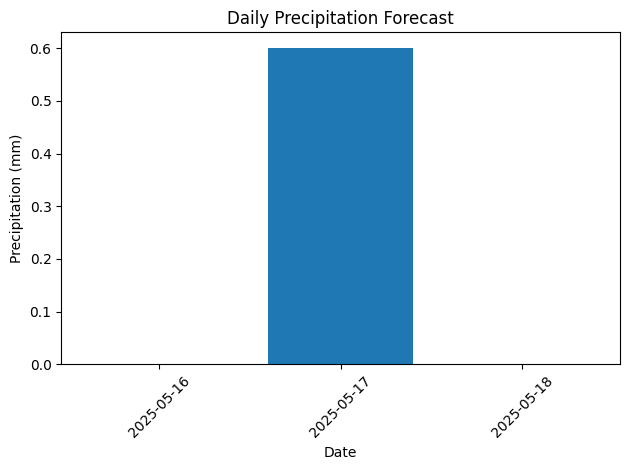

In [5]:
weather = get_weather_data("Port Louis", forecast_days=3)
create_precipitation_visualisation(weather)

**Temperature Chart**

In [6]:
  def create_temperature_visualisation(weather_data, output_type='display'):
    dates = []
    max_temps = []
    min_temps = []
    avg_temps = []

    for day in weather_data.get("forecast", []):
        dates.append(day.get("date"))
        max_temps.append(float(day.get("max_temp_C", 0)))
        min_temps.append(float(day.get("min_temp_C", 0)))
        avg_temps.append(float(day.get("avg_temp_C", 0)))

    fig, ax = plt.subplots()
    ax.plot(dates, max_temps, label="Max Temp (°C)", marker='o')
    ax.plot(dates, min_temps, label="Min Temp (°C)", marker='o')
    ax.plot(dates, avg_temps, label="Avg Temp (°C)", marker='o')

    ax.set_title("Daily Temperature Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()

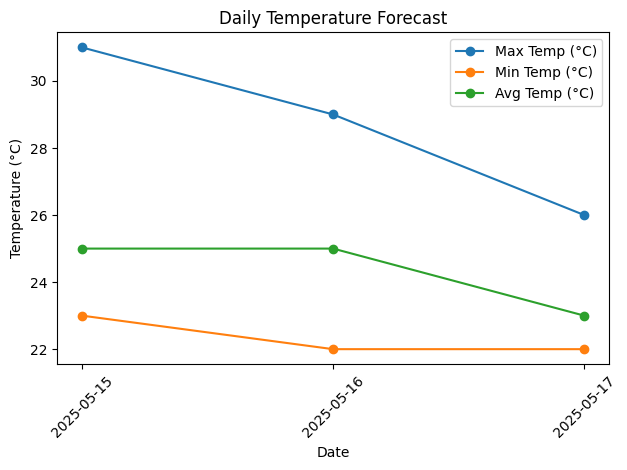

In [7]:
weather = get_weather_data("Quibdo", forecast_days=3)
create_temperature_visualisation(weather)

# **🤖 Section 3. Natural Language Processing**

This section allows the system to understand and interpret user weather-related questions written in natural language. It extracts key components such as:

🏙️ Location: City or region mentioned in the question

📆 Date: Interprets terms like "today", "tomorrow", "day after tomorrow", or absolute dates (e.g., "May 17")

🌦️ Attribute: Detects interest in specific weather conditions (e.g., rain, heat, cold)

***Getting user questions!!***

This section extract key words from structured weather data based on users questions.

In [13]:
def parse_weather_question(question):
    question = question.lower().strip()
    today = datetime.now().date()

    # ⏱️ Handle common natural phrases
    if "yesterday" in question:
        return {"error": "⏳ I can’t provide weather for the past."}
    elif "today" in question:
        parsed_date = today
    elif "tomorrow" in question:
        parsed_date = today + timedelta(days=1)
    elif "day after tomorrow" in question:
        parsed_date = today + timedelta(days=2)
    elif re.search(r"in\s+2\s+days", question):
        parsed_date = today + timedelta(days=2)
    elif re.search(r"in\s+3\s+days", question):
        parsed_date = today + timedelta(days=3)
    else:
        # Try to extract a weekday manually
        day_match = re.search(r"(monday|tuesday|wednesday|thursday|friday|saturday|sunday)", question)
        if day_match:
            parsed_dt = dateparser.parse(day_match.group(1), settings={'PREFER_DATES_FROM': 'future'})
        else:
            parsed_dt = dateparser.parse(question, settings={'PREFER_DATES_FROM': 'future'})

        if not parsed_dt:
            return {"error": "❌ Sorry, I couldn't understand the date in your question."}
        parsed_date = parsed_dt.date()

    # 🔢 Determine forecast day
    forecast_day = (parsed_date - today).days
    if forecast_day < 0:
        return {"error": "⏳ I can’t provide weather for the past."}
    if forecast_day > 2:
        return {"error": "⚠️ Only up to 3 days of forecast are supported."}

    # 🏙️ Extract and clean city name
    city_match = re.search(r"(?:in|at|for)\s+([a-z\s]{3,})", question)
    if not city_match:
        return {"error": "⚠️ Please include a city in your question using phrases like 'in Tokyo' or 'for Melbourne'."}

    location = city_match.group(1).strip()

    # Clean up date words from location
    date_words = [
        'yesterday', 'today', 'tomorrow', 'day', 'after', 'on', 'in', 'at', 'for',
        'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
        'next', 'week', 'may', 'june', 'july', 'august', 'september',
        'october', 'november', 'december', '2', '3'
    ]
    for word in date_words:
        location = re.sub(rf"\b{word}\b", "", location)
    location = re.sub(r'\s+', ' ', location).strip()

    if not location:
        return {"error": "❌ Sorry, I couldn't detect the city in your question."}

    # 🌦️ Optional weather attribute
    attribute = None
    if "rain" in question:
        attribute = "rain"
    elif "hot" in question:
        attribute = "hot"
    elif "cold" in question or "freezing" in question:
        attribute = "cold"

    return {
        "location": location,
        "forecast_day": forecast_day,
        "attribute": attribute
    }

Testing parse_weather_question function



### 🧭 How to Ask a Weather Question
- 🌤️ You can ask about the weather forecast **up to 3 days from today**.
- 📍 Your question **must include a city** and a **time reference** like:
  - `tomorrow`, `in 2 days`, `on Friday`, `Saturday`, etc.
- ✅ Examples:
  - `"Will it rain in Tokyo tomorrow?"`
  - `"What’s the weather in Perth on Friday?"`



In [15]:
question="Will it rain in Tokyo on saturday?"
parsed=parse_weather_question(question)
print(parsed)

{'location': 'tokyo', 'forecast_day': 1, 'attribute': 'rain'}


***Answering user questions***

This section transforms structured weather data into user-friendly natural language answers based on the user's question.


In [16]:
def generate_weather_response(parsed_question, weather_data):
    """
    Turn parsed data + weather data into a user-friendly reply.
    """
    if "error" in parsed_question:
        return f"❌ {parsed_question['error']}"

    location = parsed_question["location"].title()
    forecast_day = parsed_question["forecast_day"]
    attr = parsed_question["attribute"]

    if forecast_day == 0:
        data = weather_data["current_conditions"]
        response = (
            f"Today in {location}, it's currently {data['weather'].lower()}, "
            f"{data['temperature_C']}°C, with {data['humidity']}% humidity and "
            f"winds at {data['windspeed_kmph']} km/h."
        )
    else:
        data = weather_data["forecast"][forecast_day]
        response = (
            f"On {data['date']} in {location}, expect {data['condition'].lower()}, "
            f"with a high of {data['max_temp_C']}°C, a low of {data['min_temp_C']}°C, "
            f"and about {data['precipMM']} mm of rain."
        )

    # Add weather type interpretation
    extra = ""
    if attr == "rain":
        precip = float(data.get("precipMM", 0))
        extra = " ☔ Yes, rain is expected." if precip > 0 else " 🌤 No rain is expected."
    elif attr == "hot":
        temp = float(data.get("max_temp_C", data.get("temperature_C", 0)))
        extra = " 🔥 Yes, it will be hot." if temp >= 28 else " 🌡️ Not particularly hot."
    elif attr == "cold":
        temp = float(data.get("min_temp_C", data.get("temperature_C", 99)))
        extra = " 🧊 Yes, it might feel cold." if temp <= 10 else " 😊 No, it shouldn't be too cold."

    return response + extra

### 🧭 How to Ask a Weather Question
- 🌤️ You can ask about the weather forecast **up to 3 days from today**.
- 📍 Your question **must include a city** and a **time reference** like:
  - `tomorrow`, `in 2 days`, `on Friday`, `Saturday`, etc.
- ✅ Examples:
  - `"Will it rain in Tokyo tomorrow?"`
  - `"What’s the weather in Perth on Friday?"`



In [17]:
question ="Will it rain in Tokyo tomorrow?"
parsed = parse_weather_question(question)
weather_data = get_weather_data(parsed["location"], forecast_days=parsed["forecast_day"] + 1)
print(generate_weather_response(parsed, weather_data))

On 2025-05-17 in Tokyo, expect patchy rain nearby, with a high of 22°C, a low of 20°C, and about 5.599999999999999 mm of rain. ☔ Yes, rain is expected.


In [49]:
# 💃 Datos persistentes
forecast_days = 3
city_forecast_list = []
added_cities = []

# 🎨 Iconos según el clima
def get_weather_icon(condition):
    condition = condition.lower()
    if "sun" in condition or "clear" in condition:
        return "☀️"
    elif "partly" in condition and "cloud" in condition:
        return "🌤️"
    elif "cloud" in condition:
        return "☁️"
    elif "rain" in condition or "drizzle" in condition:
        return "🌧️"
    elif "thunder" in condition:
        return "⛈️"
    elif "snow" in condition:
        return "❄️"
    elif "fog" in condition or "mist" in condition:
        return "🌫️"
    else:
        return "🌡️"

# 📊 Mostrar tabla
def show_forecast_table():
    if not city_forecast_list:
        print("No forecasts to display.")
        return
    df = pd.DataFrame(city_forecast_list)
    df["icon"] = df["condition"].apply(get_weather_icon)
    df = df[["city", "date", "icon", "condition", "max_temp_C", "min_temp_C", "avg_temp_C", "precipMM", "humidity", "windspeed_kmph"]]
    display(df)

# 🌡️ Gráfico de temperaturas
def plot_temperature_chart(data):
    df = pd.DataFrame(data)
    df["max_temp_C"] = df["max_temp_C"].astype(float)
    df["min_temp_C"] = df["min_temp_C"].astype(float)
    df["avg_temp_C"] = df["avg_temp_C"].astype(float)

    fig, ax = plt.subplots()
    ax.plot(df["date"], df["max_temp_C"], label="Max Temp (°C)", marker="o")
    ax.plot(df["date"], df["min_temp_C"], label="Min Temp (°C)", marker="o")
    ax.plot(df["date"], df["avg_temp_C"], label="Avg Temp (°C)", marker="o")

    ax.set_title("Daily Temperature Forecast")
    ax.set_ylabel("°C")
    ax.set_xlabel("Date")
    plt.xticks(rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

# 🌧️ Gráfico de precipitación
def plot_precip_chart(data):
    df = pd.DataFrame(data)
    df["precipMM"] = df["precipMM"].astype(float)
    fig, ax = plt.subplots()
    ax.bar(df["date"], df["precipMM"])
    ax.set_title("Daily Precipitation Forecast")
    ax.set_ylabel("Precipitation (mm)")
    ax.set_xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 🧐 UI principal
def interactive_multi_day_city_weather_ui():
    global forecast_days, city_forecast_list, added_cities

    input_box = widgets.Text(
        placeholder='e.g. What’s the weather in Sydney tomorrow?',
        description='Your Question:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='100%')
    )

    ask_more = ToggleButtons(
        options=["Yes", "No"],
        description='Add another city?',
        disabled=True,
        style={'description_width': 'initial'}
    )

    clear_btn = Button(description="Clear All", button_style='danger')
    output_area = Output()
    detail_area = Output()
    chart_area = Output()

    def reset_all():
        global city_forecast_list, added_cities
        city_forecast_list = []
        added_cities = []
        ask_more.disabled = True
        ask_more.value = None
        with output_area: clear_output()
        with detail_area: clear_output()
        with chart_area: clear_output()

    def add_city_forecasts(city_name):
        try:
            data = get_weather_data(city_name, forecast_days=forecast_days)
            if "forecast" not in data:
                return False
            for day in data["forecast"]:
                day["city"] = city_name.title()
                city_forecast_list.append(day)
            added_cities.append(city_name.title())

            with chart_area:
                clear_output()
                plot_temperature_chart(data["forecast"])
                plot_precip_chart(data["forecast"])
            return True
        except:
            return False

    def on_submit(change):
        reset_all()
        question = input_box.value.strip()
        with output_area:
            clear_output()
            parsed = parse_weather_question(question)
            if "error" in parsed:
                print("❌", parsed["error"])
                return
            city = parsed["location"]
            success = add_city_forecasts(city)
            if success:
                print(f"✅ {forecast_days}-day forecast for {city.title()} added.")
                show_forecast_table()
                ask_more.disabled = False
            else:
                print(f"⚠️ Could not retrieve weather for '{city.title()}'.")

    def on_toggle_add(change):
        if change["new"] == "Yes":
            with detail_area:
                clear_output()
                city_input = widgets.Text(description='Next city:', placeholder="e.g. Melbourne")
                confirm_button = Button(description="Add", button_style='success')

                def on_add_clicked(b):
                    city_name = city_input.value.strip()
                    if not city_name:
                        print("⚠️ Please enter a city.")
                        return
                    if city_name.title() in added_cities:
                        print("⚠️ City already added.")
                        return
                    success = add_city_forecasts(city_name)
                    if success:
                        with output_area:
                            clear_output()
                            print(f"✅ Added forecast for {city_name.title()}")
                            show_forecast_table()
                        detail_area.clear_output()
                    else:
                        print(f"❌ Could not retrieve weather for '{city_name.title()}'.")

                confirm_button.on_click(on_add_clicked)
                display(VBox([city_input, confirm_button]))

        elif change["new"] == "No":
            with detail_area:
                clear_output()
                print("✅ Final comparison:")
                show_forecast_table()

    def on_clear_clicked(b):
        reset_all()
        input_box.value = ""

    input_box.on_submit(on_submit)
    ask_more.observe(on_toggle_add, names="value")
    clear_btn.on_click(on_clear_clicked)

    display(VBox([input_box, output_area, chart_area, ask_more, detail_area, clear_btn]))

In [50]:
interactive_multi_day_city_weather_ui()